a)

In [1]:
#Import relevant packages
from datetime import datetime
# Set relevant information
sett_date = datetime.strptime("21-09-2020","%d-%m-%Y")
issue_date = datetime.strptime("31-07-2020","%d-%m-%Y")
first_coupon_date = datetime.strptime("01-02-2021","%d-%m-%Y")
notional = 25000
coupon_r = 0.0675
CPI_sett = 251.14721
CPI_issue = 237.14365

In [2]:
#Compute inflation rate between issue and settlement, considering settlement date = 21/09/2020
inflation_r = CPI_sett/CPI_issue - 1

#Compute inflation rate daily
days_issue_to_set = (sett_date - issue_date).days
inflation_rd = (inflation_r + 1)**(1/days_issue_to_set) -1


#Compute cumulative inflation rate at 1st coupon date
days_issue_to_coupon = (first_coupon_date - issue_date).days
adjusted_coupon_r = (coupon_r/2) * (1+inflation_rd)**days_issue_to_coupon

#Compute accrued interest 
coupon_amount_adjusted = adjusted_coupon_r * notional
accrued_interest = coupon_amount_adjusted * days_issue_to_set/days_issue_to_coupon

accrued_interest

290.8653009479451

b)

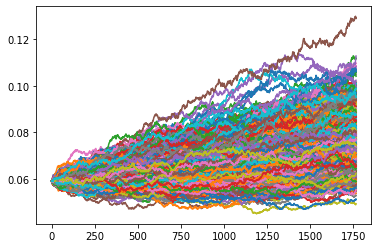

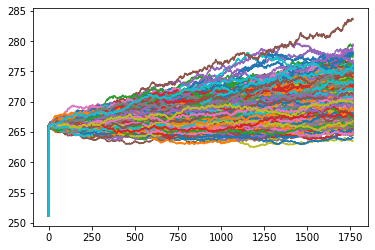

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math

#Establish the function that will simulate the irs
def ir_loop(nsim, t, mu , sigma , S0, dt):

  ir = np.zeros((nsim,t))# create the CPI Index ir values matrix (nºsimulations x days for each simulation)
  cpi = np.zeros((nsim,t))# create the inflation rate curve values matrix (nºsimulations x days for each simulation)

  #For each simulation
  for simu in range(0, nsim):

    # establish initial values
    ir[simu][0] = S0 # every inflation rate ir simulation starts with the initial inflation reference Index Level at Settlement
    cpi[simu][0] = 251.14721 # every cpi curve simulation starts at 251.14721

    # for each day within a simulation
    for day in range(1,t):

      epsilon = np.random.normal()# get a random number from the numpy normal dist
      dt = 1 / 365

      # calculate the Inflation Rate for this simulation day using the ir formula
      ir[simu][day] = ir[simu][day-1] * math.exp((mu - sigma * sigma / 2) * dt + sigma * epsilon * math.sqrt(dt))

      # calculate the CPI index
      cpi[simu][day] = cpi[simu][0]*(1+ir[simu][day])

  return ir,cpi

#Parameters
nsim = 1000 # number of simulation curves we want
t = 1766 # number of simulation days
mu = 0.05321
sigma = 0.06358
S0 = 251.14721/237.14365 - 1 #initial inflation Rference Index Level at Settlement

#Call the ir function
ir,cpi = ir_loop(nsim, t, mu, sigma, S0, 1/365)

#Plot the results
plt.figure(1)
for row in ir:
  fi1 = plt.plot(range(t), row)

plt.figure(2)
for row in cpi:
    plt.plot(range(t), row)

c)

In [4]:
import QuantLib as ql

#Use Quantlib to get all the coupon payments for our bond
date_settlement=ql.Date(19, 9, 2020)
date1 = ql.Date(31, 7, 2020)# day month year
date2 = ql.Date(21, 7, 2025)
tenor = ql.Period(ql.Semiannual)
calendar = ql.UnitedStates()
schedule = ql.Schedule(date1, date2, tenor, calendar, ql.Following,
                           ql.Following, ql.DateGeneration.Forward, False)

# Will save the days from the settlement to a coupon payment. This way we can get the values from the simulations 
#for the maturity dates
coupon_dates_days = []

# Gets the coupon_payment_date- bond_settlement_date differences so we know which days in the days array
# correspond to coupo payment dates
for d in schedule:
    print(d)
    if d>date_settlement: #only coupon payments after settlement
        coupon_dates_days.append(d-date_settlement-1)

coupon_dates_days

July 31st, 2020
February 1st, 2021
August 2nd, 2021
January 31st, 2022
August 1st, 2022
January 31st, 2023
July 31st, 2023
January 31st, 2024
July 31st, 2024
January 31st, 2025
July 21st, 2025


[134, 316, 498, 680, 863, 1044, 1228, 1410, 1594, 1765]

In [5]:
#ILB coupon = RealCoupon * Compounded inflation
#Compounded inflation = (1+InflationRate(t)), for t == 0
#                      = (1+InflationRate(t))*(1+InflationRate(t-1)), for t>0

#Cash flows = ILB coupon (t), for t>0
#           = ILB Coupon(t_final)+FV, for t=maturity


#Variable reminder
nsim = 1000
t = 1766
cf = np.zeros((nsim,t))
notion_principal = 25000
real_coupon = 0.065/2 #coupon for semi-annual payment
comp_inf=0# coumpounded inflation

#For each simulation of the inflation rate
for nsim, sim in enumerate(ir):

    #For each coupon payment date
    for ncoup_payment, coup_pay in enumerate(coupon_dates_days):

        #If it is the first coupon payment in this simulation
        if ncoup_payment == 0:
            comp_inf = 1+sim[coup_pay] # sim[coup_pay] is the inf_rate value of this simulation 
                                        #at the date of a coupon payment
            cf[nsim][coup_pay]=comp_inf*real_coupon*notion_principal

        #If it is not the first nor the last coupon payment
        elif ncoup_payment>0 and ncoup_payment<len(coupon_dates_days)-1:
            comp_inf = (1+sim[coup_pay])*comp_inf
            cf[nsim][coup_pay]=comp_inf*real_coupon*notion_principal
        
        #If it is the last coupon payment
        else:
            comp_inf = (1+sim[coup_pay])*comp_inf
            cf[nsim][coup_pay]=comp_inf*real_coupon*notion_principal+notion_principal*comp_inf

print(np.nonzero(cf[50])) #see if the cashflows of a random sim (in this case simulation 50) are only
                          #positive at the days where coupon payments occur
cf[cf>0]#get the positive values (the cash flows)


(array([ 134,  316,  498,  680,  863, 1044, 1228, 1410, 1594, 1765],
      dtype=int64),)


array([  861.35884685,   918.43194469,   984.98254893, ...,
        1504.7625296 ,  1649.17560548, 57374.43311306])

In [6]:
# Get the yield curve with the NSS parameters

import pandas as pd
from scipy.optimize import minimize


#Establish figure size
plt.figure(figsize=(8,5))

#Calculates the NSS estimated interest rate for a certain set of variables and a certain maturity
def nss(p, term):
    beta0, beta1, beta2, beta3, tau1, tau2 = p
    return ( beta0
            +beta1*(1-np.exp(-term/tau1))/(term/tau1)
            +beta2*((1-np.exp(-term/tau1))/(term/tau1)-np.exp(-term/tau1))
            +beta3*((1-np.exp(-term/tau2))/(term/tau2)-np.exp(-term/tau2)))


nsim = 1000

maturities_month =[0.5,   1,   1.5,  2,   2.5, 3,   3.5,  4,   4.5, 5]

# get all the NSSparams calculated for this date (index)
p = [0.059, -0.016, -0.005, 0.01, 5, 0.5]

# get the NSS formula values corresponding to the maturity points we defined previously
nss_yc = np.array([nss(p, mat) for mat in maturities_month])
nss_yc



array([0.04618246, 0.04703035, 0.04723087, 0.04731446, 0.04742609,
       0.04759021, 0.04779864, 0.04803776, 0.04829588, 0.04856437])

<Figure size 576x360 with 0 Axes>

In [7]:
#Estimate fair value
# FV = sum{CF(n)/(1+r(t)^t}) + (CF(n)+Nominal_Val)/(1+r(mat)^mat}
maturities_month =[0.5,   1,   1.5,  2,   2.5, 3,   3.5,  4,   4.5, 5]
fv = np.zeros((nsim))

#For each simulation cash flow
for ind, cash_flow in enumerate(cf):

    #For each coupon payment day
    for index,coup_pay in enumerate(coupon_dates_days):

        #Get the coupon payment value adjusted to inflation, previously calculated
        payment = cash_flow[coup_pay]

        #Get the interest rate from the previously calculated NSS
        interest_rate = nss_yc[index]

        #Get the face value
        fv[ind]=fv[ind]+payment/(1+interest_rate)**maturities_month[index]



d)

The chance of getting an estimated present value higher then the notional amount is:  100.0 %
The chance of getting an estimated present value higher then the notional amount is:  0.0 %


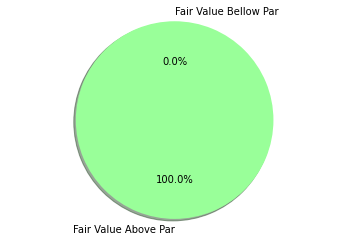

The mean is 48231.144802990915 and the variance is 5812574.796044676
The maximum value of the bond is 60933.71868982396 and the minimum is 42068.94378958661


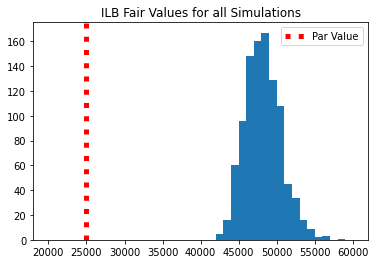

In [8]:
from matplotlib import pyplot as plt

above_par = (fv > 25000).sum()
bellow_par = (fv < 25000).sum()
print("The chance of getting an estimated present value higher then \
the notional amount is: ",above_par/len(fv) *100,"%")
print("The chance of getting an estimated present value higher then \
the notional amount is: ",bellow_par/len(fv) *100,"%")
explode = (0, 0)
fig1, ax1 = plt.subplots()
colors = ['#99ff99','#ff9999']
ax1.pie([above_par, bellow_par], explode=explode, labels=['Fair Value Above Par','Fair Value Bellow Par'] ,
        colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


mean =np.mean(fv)
var =np.var(fv)
print("The mean is",mean,"and the variance is",var)
print("The maximum value of the bond is", fv.max(), "and the minimum is", fv.min())

bins_step = np.arange(20000, fv.max(), 1000)
plt.hist(fv, bins = bins_step)
 
plt.title("ILB Fair Values for all Simulations")
plt.axvline(x=25000, ymin=0, color='red', linestyle='dotted', linewidth=5, label= 'Par Value')
plt.legend(loc = 'upper right')
# show plot
plt.show()